<a href="https://colab.research.google.com/github/leopapuma/proyecto/blob/main/proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

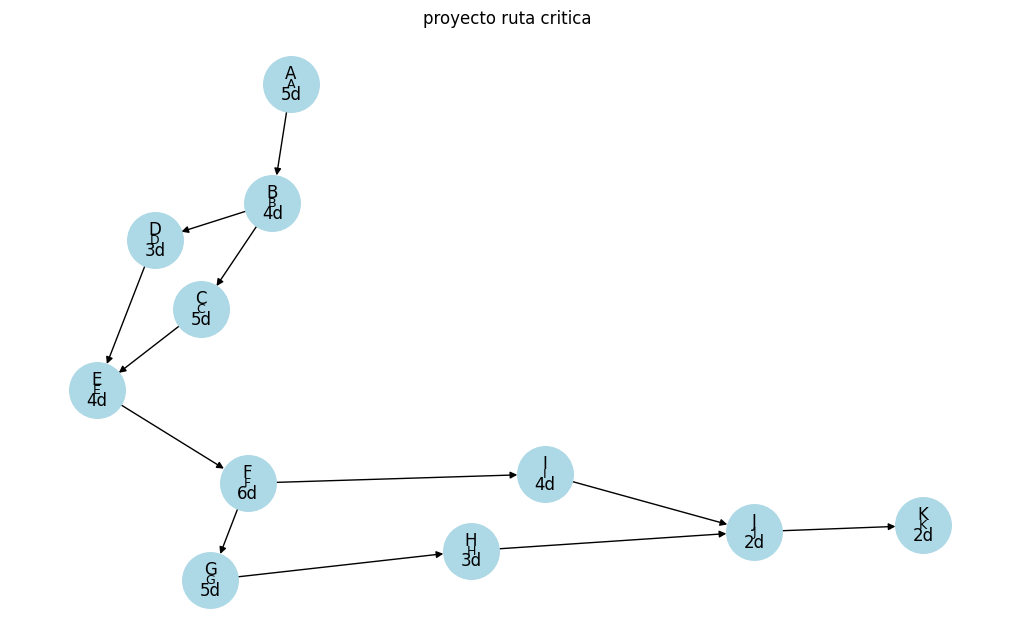

Duración del proyecto: 36 días
actividad: ['A', 'B', 'C', 'E', 'F', 'G', 'H', 'J', 'K']


,Actividad,Nombre,Duracion,ES,EF,LS,LF,Slack
0,A,Recolectar datos,5,0,5,0,5,0
1,B,Limpieza de datos,4,5,9,5,9,0
2,C,Ingeniería de variables,5,9,14,9,14,0
3,D,EDA y visualización,3,9,12,11,14,2
4,E,modelo arma,4,14,18,14,18,0
5,F,Entrenamiento,6,18,24,18,24,0
6,G,Backtesting OOS,5,24,29,24,29,0
7,I,Infra & API,4,24,28,28,32,4
8,H,Optimización ejecución,3,29,32,29,32,0
9,J,Despliegue en staging,2,32,34,32,34,0


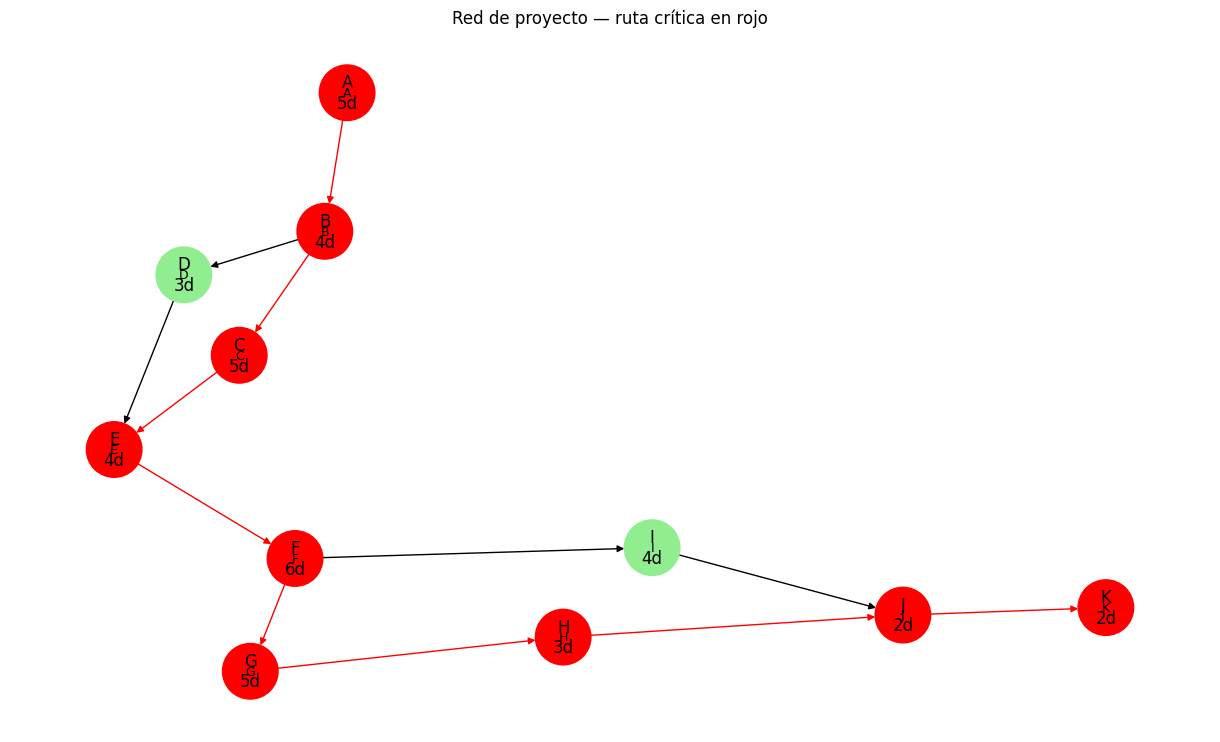

In [18]:
# en este proyecto usaremos la ruta mas critica, para hacer un modelo de predicion bursatil,
# especificamente cual ruta conviene usar mas para hacer una evalucion de acciones
# importamos las librerias que se van usar para el proyecto
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# creamos los nodos que usaremos para la predecion de precios, explicaremos que hace cada nodo
# nota no es nesesario seguir todos estos pasos para hacer una predecion de precios, los usaremos para construir una red un poco grande
modelo = {
    'A': {'name': 'Recolectar datos', 'dur': 5, 'pred': []}, # en el nodo A recoletaremos los datos como el balance general, cada de flujo, maximos historicos
    #y los precios en 10 años,
    'B': {'name': 'Limpieza de datos', 'dur': 4, 'pred': ['A']}, # en el nodo B limpiaremos datos atipicos
    'C': {'name': 'Ingeniería de variables', 'dur': 5, 'pred': ['B']}, # nodo c, la ingeneria de variables se usa para transformar y crear nuevas variables con las variables anterioeres
    'D': {'name': 'EDA y visualización', 'dur': 3, 'pred': ['B']}, # nodo D, lo que hace es una tecnica de analisis de daos que analiza los conjuntos de datos, sirve para descubrir patrones
    'E': {'name': 'modelo arma', 'dur': 4, 'pred': ['C','D']},# en el nodo E usaremos el modelo arima
    'F': {'name': 'Entrenamiento ', 'dur': 6, 'pred': ['E']},# en nodo F, se construira un modelo automatico
    'G': {'name': 'Backtesting OOS', 'dur': 5, 'pred': ['F']}, # en el nodo G se usara para probar el modelo
    'H': {'name': 'Optimización ejecución', 'dur': 3, 'pred': ['G']}, #aqui se planeara la mejor estrategia que se eleguira
    'I': {'name': 'Infra & API', 'dur': 4, 'pred': ['F']},# sirve para crear una pag wed para hacer simulaciones de tu modelo
    'J': {'name': 'Despliegue en staging', 'dur': 2, 'pred': ['I','H']},# ideal para hacer pruebas y cambios sin afectar al sitio de produccion
    'K': {'name': 'Monitoreo y doc', 'dur': 2, 'pred': ['J']} # sirve para garantizar calidad de diversos procesos
}
# construimos un grafo que este derigido
G = nx.DiGraph()
for t, d in modelo.items(): # en este for itera por cada actividad t y los datos que es d
    G.add_node(t, duration=d['dur'], label=d['name']) # aqui va añadir los nodos
    for p in d['pred']:
        G.add_edge(p, t)


try:
    grafo = nx.nx_agraph.graphviz_layout(G, prog='dot')
except Exception:
    grafo = nx.spring_layout(G, seed=42)
# graficaremos el grafo con las lineas de codigo de abajo
plt.figure(figsize=(10,6))
nx.draw(G, grafo, with_labels=True, node_size=1600, node_color="lightblue", font_size=9)
node_labels = {n: f"{n}\n{G.nodes[n]['duration']}d" for n in G.nodes()}
nx.draw_networkx_labels(G, grafo, labels=node_labels)
plt.title("proyecto ruta critica ")
plt.axis('off')
plt.show()

ES = {n: 0 for n in G.nodes()} #  iniciar el nodo a 0 para cada nodo
EF = {}

topo = list(nx.topological_sort(G))
for node in topo:
    if not list(G.predecessors(node)):
        ES[node] = 0
    else:
        ES[node] = max(EF[p] for p in G.predecessors(node))
    EF[node] = ES[node] + G.nodes[node]['duration']

# aqui calculara el maximo duracion estimada del proyecto
duracion = max(EF.values())


LF = {n: duracion for n in G.nodes()}
LS = {}

for node in reversed(topo):
    if not list(G.successors(node)):
        LF[node] = duracion
    else:
        LF[node] = min(LS[s] for s in G.successors(node))
    LS[node] = LF[node] - G.nodes[node]['duration']


Slack = {n: LS[n] - ES[n] for n in G.nodes()}

# crearemos un dataframe que contenga acticidad, nombre ,ES,EF,LS,SLACK
df = pd.DataFrame({
    'Actividad': [n for n in G.nodes()],
    'Nombre': [G.nodes[n]['label'] for n in G.nodes()],
    'Duracion': [G.nodes[n]['duration'] for n in G.nodes()],
    'ES': [ES[n] for n in G.nodes()],
    'EF': [EF[n] for n in G.nodes()],
    'LS': [LS[n] for n in G.nodes()],
    'LF': [LF[n] for n in G.nodes()],
    'Slack': [Slack[n] for n in G.nodes()]
})

# oredenaremos los datos
df = df.sort_values(by='ES').reset_index(drop=True)
df
#
x = [n for n, s in Slack.items() if s == 0]

print("Duración del proyecto:", duracion, "días")
print("actividad:", x)

# ahora mostraremos la tabla
from IPython.display import display
display(df)
# coloreamos ahora los nodos y las aristas
node_colors = []
for n in G.nodes():
    node_colors.append('red' if n in x  else 'lightgreen')

edge_colors = []
for u,v in G.edges():

    if u in critical_activities and v in x and ES[v] == EF[u]:
        edge_colors.append('red')
    else:
        edge_colors.append('black')
# surallaremos ahora los nodos con la mejor ruta para el proyecto
plt.figure(figsize=(12,7))
nx.draw(G, grafo, with_labels=True, node_size=1600, node_color=node_colors, font_size=9, edge_color=edge_colors)
nx.draw_networkx_labels(G, grafo, labels=node_labels)
plt.title("Red de proyecto — ruta crítica en rojo") # imprime el titulo
plt.axis('off') # vamos hacer sin ejes
plt.show() # mostra el resultado final del grafo
# imprimiendo el codigo encontramos que la duracion de proyecto sera de 36 dias, la activida que tiene que hacer es las
# siguiente  ['A', 'B', 'C', 'E', 'F', 'G', 'H', 'J', 'K']



